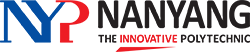

# IT2311 Assignment - Task 1b: Topic Modelling

Complete the following sub-tasks:
1.	**Load Data**: Load the clean dataset
2.	**Data Preparation**: Prepares the text representation for this task
3.	**Modelling**: Perform topic modelling and identify the suitable topic number
4.	**Evaluation**: Evaluates the results and identify the topic

For each sub-task, perform the necessary steps and **explain the rationale taken for each step in the Jupyter notebook**. 

**Done by: Clifton Chen Yi, 231220B**

## Import libraries and download the packages

In [ ]:
# Install required packages
!pip install gensim pyLDAvis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Gensim for LDA topic modelling
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# NLTK for text processing
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# For visualisation
try:
    import pyLDAvis
    import pyLDAvis.gensim_models as gensimvis
    PYLDAVIS_AVAILABLE = True
except ImportError:
    PYLDAVIS_AVAILABLE = False
    print('pyLDAvis not available. Install with: pip install pyLDAvis')

from collections import Counter

%matplotlib inline
print('All libraries imported successfully.')

## Load Data

**Rationale:** We load the cleaned dataset from Task 1a. This dataset has already been preprocessed — text has been lowercased, special characters removed, stop words removed, and words lemmatised.

In [ ]:
# Load the cleaned data from Task 1a
df = pd.read_csv('cleaned_world_bank_data.csv')
print(f'Loaded {len(df)} documents')
print(f'Columns: {list(df.columns)}')
df.head()

In [ ]:
# Quick check on loaded data
print(f'Dataset shape: {df.shape}')
print(f'\nDocument type distribution:')
print(df['document_type'].value_counts())
print(f'\nMissing values in cleaned_text: {df["cleaned_text"].isnull().sum()}')

# Drop any rows with missing cleaned_text
df = df.dropna(subset=['cleaned_text'])
print(f'Final document count: {len(df)}')

## Data Preparation

**Rationale:** For LDA (Latent Dirichlet Allocation) topic modelling, we need to:
1. **Tokenise** the cleaned text into lists of words
2. Create a **dictionary** mapping words to unique integer IDs
3. Create a **corpus** in bag-of-words format required by Gensim's LDA

We also filter out extremely rare and extremely common words from the dictionary, as these do not contribute meaningfully to topic differentiation.


### 2.1 Tokenisation

**Rationale:** Tokenisation splits each document's cleaned text into individual words (tokens). This is the required input format for building the Gensim dictionary and corpus.

In [ ]:
# Tokenise the cleaned text
df['tokens'] = df['cleaned_text'].apply(lambda x: str(x).split())

print(f'Tokenisation complete.')
print(f'Average tokens per document: {df["tokens"].apply(len).mean():.1f}')
print(f'\nSample tokens (first document, first 20 words):')
print(df['tokens'].iloc[0][:20])

### 2.2 Build Dictionary and Corpus

**Rationale:** The Gensim dictionary maps each unique word to an integer ID. We filter the dictionary to:
- Remove words appearing in fewer than 5 documents (too rare to be meaningful)
- Remove words appearing in more than 60% of documents (too common to differentiate topics)
- Keep only the top 10,000 most frequent words

The corpus converts each document into a bag-of-words representation: a list of (word_id, word_count) tuples.

In [ ]:
# Create the dictionary
dictionary = corpora.Dictionary(df['tokens'])
print(f'Dictionary size before filtering: {len(dictionary)}')

# Filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.6, keep_n=10000)
print(f'Dictionary size after filtering: {len(dictionary)}')

# Create the corpus (bag-of-words representation)
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]
print(f'Corpus size: {len(corpus)} documents')

# Show sample
print(f'\nSample bow representation (first document, first 10 entries):')
print(corpus[0][:10])

In [ ]:
# Examine the most common words in the dictionary
all_tokens = [token for doc in df['tokens'] for token in doc]
word_freq = Counter(all_tokens)
top_words = word_freq.most_common(30)

print('Top 30 most common words across all documents:')
for word, freq in top_words:
    print(f'  {word}: {freq}')

# Visualise
plt.figure(figsize=(12, 6))
words, freqs = zip(*top_words)
plt.barh(range(len(words)), freqs, color='steelblue')
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency')
plt.title('Top 30 Most Common Words')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Modelling

**Rationale:** We use **Latent Dirichlet Allocation (LDA)** as our topic modelling technique. LDA is selected because:

1. **Widely used and well-understood**: LDA is one of the most established topic modelling algorithms, making results interpretable and comparable.
2. **Probabilistic approach**: LDA models each document as a mixture of topics and each topic as a mixture of words, providing rich probabilistic interpretations.
3. **Suitable for document classification**: The World Bank documents can be categorised into meaningful topics based on their content.
4. **Hyperparameter tuning**: LDA allows tuning of key parameters (number of topics, alpha, eta) to optimise results.

**Approach:**
- First, train LDA models with varying numbers of topics (from 3 to 15)
- Use coherence scores to identify the optimal number of topics
- Then perform hyperparameter tuning on alpha and eta
- Select the best-performing model based on coherence score


### 3.1 Finding Optimal Number of Topics

**Rationale:** The number of topics is the most critical hyperparameter in LDA. We train models with different topic numbers and evaluate each using the **coherence score** (c_v measure). Higher coherence scores indicate more interpretable and meaningful topics. We test a range from 3 to 15 topics.

In [ ]:
# Function to compute coherence scores for different numbers of topics
def compute_coherence_values(dictionary, corpus, texts, start=3, stop=16, step=1):
    """
    Compute coherence scores for LDA models with different numbers of topics.
    
    Parameters:
    - dictionary: Gensim dictionary
    - corpus: Gensim corpus
    - texts: List of tokenised documents
    - start: Minimum number of topics
    - stop: Maximum number of topics (exclusive)
    - step: Step size
    
    Returns:
    - model_list: List of trained LDA models
    - coherence_values: List of coherence scores
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, stop, step):
        print(f'Training LDA model with {num_topics} topics...')
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha='auto',
            eta='auto',
            per_word_topics=True
        )
        model_list.append(model)
        
        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())
        print(f'  Coherence Score: {coherence_values[-1]:.4f}')
    
    return model_list, coherence_values

# Compute coherence values
start, stop, step = 3, 16, 1
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=df['tokens'].tolist(),
    start=start,
    stop=stop,
    step=step
)

In [ ]:
# Plot coherence scores
topic_range = range(start, stop, step)

plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_values, 'b-o', linewidth=2, markersize=8)
plt.xlabel('Number of Topics', fontsize=12)
plt.ylabel('Coherence Score (c_v)', fontsize=12)
plt.title('Coherence Score vs Number of Topics', fontsize=14)
plt.xticks(list(topic_range))
plt.grid(True, alpha=0.3)

# Highlight the best score
best_idx = np.argmax(coherence_values)
best_topics = list(topic_range)[best_idx]
best_coherence = coherence_values[best_idx]
plt.scatter([best_topics], [best_coherence], color='red', s=200, zorder=5, label=f'Best: {best_topics} topics ({best_coherence:.4f})')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f'\nOptimal number of topics: {best_topics}')
print(f'Best coherence score: {best_coherence:.4f}')

# Show all scores
print(f'\nAll coherence scores:')
for num, score in zip(topic_range, coherence_values):
    marker = ' <-- Best' if num == best_topics else ''
    print(f'  {num} topics: {score:.4f}{marker}')

### 3.2 Hyperparameter Tuning

**Rationale:** After identifying the optimal number of topics, we fine-tune the LDA model's hyperparameters:
- **alpha**: Controls document-topic density. Lower alpha means documents are composed of fewer topics.
- **eta (beta)**: Controls topic-word density. Lower eta means topics are composed of fewer words.

We test different combinations of alpha and eta values to find the configuration that maximises coherence.

In [ ]:
# Hyperparameter tuning with different alpha and eta values
optimal_topics = best_topics

alpha_values = ['symmetric', 'asymmetric', 0.01, 0.1, 0.5]
eta_values = ['symmetric', 0.01, 0.1, 0.5]

tuning_results = []

print(f'Tuning hyperparameters for {optimal_topics} topics...')
print('='*60)

for alpha in alpha_values:
    for eta in eta_values:
        try:
            model = LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=optimal_topics,
                random_state=42,
                passes=10,
                alpha=alpha,
                eta=eta,
                per_word_topics=True
            )
            
            coherencemodel = CoherenceModel(
                model=model,
                texts=df['tokens'].tolist(),
                dictionary=dictionary,
                coherence='c_v'
            )
            coherence = coherencemodel.get_coherence()
            
            tuning_results.append({
                'alpha': str(alpha),
                'eta': str(eta),
                'coherence': coherence
            })
            print(f'alpha={str(alpha):12s}, eta={str(eta):10s} -> Coherence: {coherence:.4f}')
        except Exception as e:
            print(f'alpha={str(alpha):12s}, eta={str(eta):10s} -> Error: {e}')

# Find best combination
tuning_df = pd.DataFrame(tuning_results)
best_result = tuning_df.loc[tuning_df['coherence'].idxmax()]
print(f'\n{"="*60}')
print(f'Best hyperparameters:')
print(f'  alpha = {best_result["alpha"]}')
print(f'  eta = {best_result["eta"]}')
print(f'  Coherence = {best_result["coherence"]:.4f}')

In [ ]:
# Visualise tuning results
plt.figure(figsize=(12, 6))
tuning_df['label'] = tuning_df['alpha'] + ' / ' + tuning_df['eta']
colors = ['red' if c == tuning_df['coherence'].max() else 'steelblue' for c in tuning_df['coherence']]
plt.barh(range(len(tuning_df)), tuning_df['coherence'], color=colors)
plt.yticks(range(len(tuning_df)), tuning_df['label'], fontsize=8)
plt.xlabel('Coherence Score (c_v)')
plt.title(f'Hyperparameter Tuning Results ({optimal_topics} Topics)')
plt.tight_layout()
plt.show()

### 3.3 Train Final Model

**Rationale:** We train the final LDA model using the optimal number of topics and the best hyperparameters identified through tuning.

In [ ]:
# Train the final model with best hyperparameters
# Convert string values back for gensim
best_alpha = best_result['alpha']
best_eta = best_result['eta']

# Handle string/numeric alpha values
try:
    best_alpha = float(best_alpha)
except ValueError:
    pass  # Keep as string ('symmetric' or 'asymmetric')

try:
    best_eta = float(best_eta)
except ValueError:
    pass  # Keep as string ('symmetric')

print(f'Training final model with {optimal_topics} topics, alpha={best_alpha}, eta={best_eta}')

final_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=optimal_topics,
    random_state=42,
    passes=20,
    alpha=best_alpha,
    eta=best_eta,
    per_word_topics=True,
    iterations=400
)

# Compute final coherence
final_coherence = CoherenceModel(
    model=final_model,
    texts=df['tokens'].tolist(),
    dictionary=dictionary,
    coherence='c_v'
).get_coherence()

print(f'Final model coherence score: {final_coherence:.4f}')

## Evaluation

**Rationale:** We evaluate the final LDA model by:
1. Examining the top words in each topic to understand what each topic represents
2. Computing per-topic coherence to identify strong and weak topics
3. Analysing the document-topic distribution
4. Visualising topics interactively (if pyLDAvis is available)
5. Proposing human-readable topic labels based on the top words


### 4.1 Topic Words

**Rationale:** The top words in each topic reveal what the topic is about. We examine the 15 most probable words in each topic to understand and label them.

In [ ]:
# Display topics with top words
print(f'\n{"="*70}')
print(f'FINAL LDA MODEL - {optimal_topics} TOPICS')
print(f'Overall Coherence Score: {final_coherence:.4f}')
print(f'{"="*70}\n')

for idx, topic in final_model.print_topics(num_words=15):
    print(f'Topic {idx}: {topic}')
    print()

In [ ]:
# Visualise topic-word distributions
fig, axes = plt.subplots(nrows=(optimal_topics + 1) // 2, ncols=2, figsize=(16, 4 * ((optimal_topics + 1) // 2)))
axes = axes.flatten()

for idx in range(optimal_topics):
    topic_words = final_model.show_topic(idx, topn=10)
    words = [w for w, _ in topic_words]
    weights = [w for _, w in topic_words]
    
    axes[idx].barh(range(len(words)), weights, color='steelblue')
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words)
    axes[idx].set_title(f'Topic {idx}')
    axes[idx].invert_yaxis()

# Hide any unused subplots
for idx in range(optimal_topics, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Top 10 Words per Topic', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 4.2 Per-Topic Coherence

**Rationale:** Per-topic coherence helps identify which topics are well-defined and which may need improvement. Low-coherence topics may represent noise or overlapping themes.

In [ ]:
# Compute per-topic coherence
topic_coherences = []
for idx in range(optimal_topics):
    topic_words = [w for w, _ in final_model.show_topic(idx, topn=10)]
    try:
        cm = CoherenceModel(
            topics=[topic_words],
            texts=df['tokens'].tolist(),
            dictionary=dictionary,
            coherence='c_v'
        )
        score = cm.get_coherence()
    except Exception:
        score = 0.0
    topic_coherences.append(score)
    print(f'Topic {idx}: Coherence = {score:.4f}')

# Visualise
plt.figure(figsize=(10, 5))
colors = ['coral' if c < np.mean(topic_coherences) else 'steelblue' for c in topic_coherences]
plt.bar(range(optimal_topics), topic_coherences, color=colors)
plt.axhline(y=np.mean(topic_coherences), color='red', linestyle='--', label=f'Mean: {np.mean(topic_coherences):.4f}')
plt.xlabel('Topic')
plt.ylabel('Coherence Score')
plt.title('Per-Topic Coherence Scores')
plt.xticks(range(optimal_topics))
plt.legend()
plt.tight_layout()
plt.show()

### 4.3 Document-Topic Distribution

**Rationale:** Analysing how documents are distributed across topics helps us understand topic prevalence and whether certain topics are dominant in the corpus.

In [ ]:
# Get dominant topic for each document
def get_dominant_topic(model, corpus):
    """Get the dominant topic for each document."""
    dominant_topics = []
    topic_percentages = []
    for doc_bow in corpus:
        topic_dist = model.get_document_topics(doc_bow)
        if topic_dist:
            dominant = max(topic_dist, key=lambda x: x[1])
            dominant_topics.append(dominant[0])
            topic_percentages.append(dominant[1])
        else:
            dominant_topics.append(-1)
            topic_percentages.append(0)
    return dominant_topics, topic_percentages

dominant_topics, topic_percentages = get_dominant_topic(final_model, corpus)
df['dominant_topic'] = dominant_topics
df['topic_percentage'] = topic_percentages

# Document distribution across topics
print('Document Distribution Across Topics:')
topic_dist = df['dominant_topic'].value_counts().sort_index()
for topic_id, count in topic_dist.items():
    pct = count / len(df) * 100
    print(f'  Topic {topic_id}: {count} documents ({pct:.1f}%)')

In [ ]:
# Visualise document distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
topic_dist.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Documents per Topic')
axes[0].set_xlabel('Topic')
axes[0].set_ylabel('Number of Documents')
axes[0].tick_params(axis='x', rotation=0)

# Topic distribution by document type
topic_by_type = pd.crosstab(df['dominant_topic'], df['document_type'])
topic_by_type.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_title('Topic Distribution by Document Type')
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('Number of Documents')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Document Type')

plt.tight_layout()
plt.show()

### 4.4 Interactive Topic Visualisation

**Rationale:** pyLDAvis provides an interactive visualisation that shows topic distances, sizes, and key terms. This helps validate that topics are well-separated and interpretable.

In [ ]:
# Interactive visualisation with pyLDAvis
if PYLDAVIS_AVAILABLE:
    pyLDAvis.enable_notebook()
    vis_data = gensimvis.prepare(final_model, corpus, dictionary)
    pyLDAvis.display(vis_data)
else:
    print('pyLDAvis is not installed. Skipping interactive visualisation.')
    print('To install: pip install pyLDAvis')

### 4.5 Topic Perplexity

**Rationale:** Perplexity is another evaluation metric for topic models. Lower perplexity indicates better generalisation. We report it alongside coherence for completeness.

In [ ]:
# Compute perplexity
perplexity = final_model.log_perplexity(corpus)
print(f'Log Perplexity: {perplexity:.4f}')
print(f'Perplexity: {np.exp(perplexity):.4f}')
print(f'\n(Lower perplexity indicates better model fit.)')

### 4.6 Topic Labels and Summary

**Rationale:** Based on the top words in each topic, we propose human-readable labels. These labels help stakeholders understand what each topic cluster represents in the World Bank project documents.

In [ ]:
# Generate topic summary table
topic_summary = []
for idx in range(optimal_topics):
    top_words = [w for w, _ in final_model.show_topic(idx, topn=10)]
    doc_count = topic_dist.get(idx, 0)
    coherence = topic_coherences[idx] if idx < len(topic_coherences) else 0
    topic_summary.append({
        'Topic': idx,
        'Top Words': ', '.join(top_words),
        'Document Count': doc_count,
        'Coherence': round(coherence, 4)
    })

summary_df = pd.DataFrame(topic_summary)
print('Topic Summary:')
print('='*100)
for _, row in summary_df.iterrows():
    print(f'\nTopic {row["Topic"]} ({row["Document Count"]} docs, coherence: {row["Coherence"]:.4f}):')
    print(f'  Top words: {row["Top Words"]}')

In [ ]:
# Final model summary
print('='*70)
print('FINAL MODEL SUMMARY')
print('='*70)
print(f'Technique: Latent Dirichlet Allocation (LDA)')
print(f'Number of Topics: {optimal_topics}')
print(f'Alpha: {best_alpha}')
print(f'Eta: {best_eta}')
print(f'Coherence Score (c_v): {final_coherence:.4f}')
print(f'Log Perplexity: {perplexity:.4f}')
print(f'Total Documents: {len(df)}')
print(f'Dictionary Size: {len(dictionary)}')
print(f'\nThe model was selected based on:')
print(f'  1. Coherence score optimisation across {stop - start} different topic numbers')
print(f'  2. Hyperparameter tuning across {len(tuning_results)} alpha/eta combinations')
print(f'  3. Per-topic coherence analysis to validate topic quality')

## Submission
Export your completed work as HTML. Select **File** > **Download as** > **HTML (.html)**.